**Premier réseau** :   
     - Objectif : prédire si un patient est sain ou atteint de pneumonie.  
     - Architecture basée sur des couches Conv2D et MaxPooling2D pour extraire les caractéristiques des images.  
     - Entraînement sur des images brutes redimensionnées à 16x16 pixels.  
     - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA']

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 2
epochs = 50
crossValidationSplit = 10
# Scaling input image to theses dimensions
img_rows, img_cols = 16, 16

Dans ce réseau, ni la luminosité ni le contraste ne seront modifiés. L'image sera simplement réduite à **16 x 16 pixels** et convertie en **niveaux de gris**.

In [13]:
def preprocesar_imagen(imagen_path):
    # Cargar la imagen utilizando OpenCV
    imagen = cv2.imread(imagen_path)

    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    #alpha = 1.3  # factor de contraste
    #beta = -80    # factor de brillo
    #imagen_ajustada = cv2.convertScaleAbs(imagen_gris, alpha=alpha, beta=beta)

    imagen_final = cv2.resize(imagen_gris, (img_rows, img_cols), interpolation=cv2.INTER_AREA)

    return np.array(imagen_final)


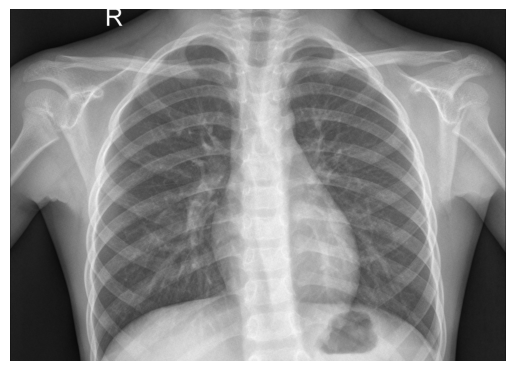

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

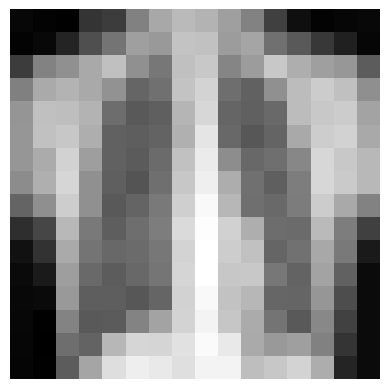

In [22]:
imagen = r"..\data\external\chest_xray\test\NORMAL\IM-0001-0001.jpeg"

normal = cv2.imread(imagen)

plt.imshow(normal)
plt.axis('off')  # Opcional: quita los ejes de la imagen
plt.show()


imagen_retocada = preprocesar_imagen(imagen)

plt.imshow(imagen_retocada, cmap='gray')  # Añadir cmap='gray'
plt.axis('off')  

In [23]:
def load_data(ruta):
    name_classes = ['NORMAL', 'PNEUMONIA']
    X, y = [], []

    # Listar las carpetas principales
    base_dirs = [ruta + r'\train', ruta + r'\val', ruta + r'\test']

    for base_dir in base_dirs:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            path = rf'{base_dir}\{class_name}\*.jpeg'
            for filename in glob.glob(path):
                im = preprocesar_imagen(filename)
                X.append(keras.preprocessing.image.img_to_array(im))
                
                # Determinar la clase en función del nombre del archivo
                if class_name == 'NORMAL':
                    y.append(0)  # Clase 0: NORMAL
                else:
                    y.append(1)  # Clase 1: PNEUMONIA_BACTERIA

    input_shape = (img_rows, img_cols, 1)
    return np.array(X), np.array(y), input_shape


In [24]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [25]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [27]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")


(5856, 16, 16, 1) échantillons d'entraînement
16 x 16 taille de l'image
(16, 16, 1) input_shape
50 epochs


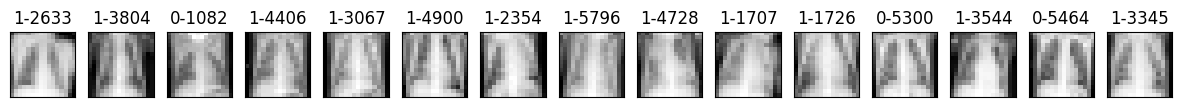

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 5s - 56ms/step - accuracy: 0.7252 - loss: 0.5764 - val_accuracy: 0.7287 - val_loss: 0.4687
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8247 - loss: 0.3859 - val_accuracy: 0.8635 - val_loss: 0.3072
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8937 - loss: 0.2509 - val_accuracy: 0.8430 - val_loss: 0.3653
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.9006 - loss: 0.2482 - val_accuracy: 0.9147 - val_loss: 0.2145
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.9287 - loss: 0.1896 - val_accuracy: 0.9283 - val_loss: 0.1879
Epoch 6/50
83/83 - 1s - 7ms/step - accuracy: 0.9313 - loss: 0.1803 - val_accuracy: 0.9300 - val_loss: 0.1936
Epoch 7/50
83/83 - 1s - 7ms/step - accuracy: 0.9376 - loss: 0.1676 - val_accuracy: 0.9300 - val_loss: 0.1758
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.9463 - loss: 0.1510 - val_accuracy: 0.9386 - val_loss: 0.1581
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.9391 - loss: 0.1595 - val_accuracy: 0.9283 - val_loss: 0.1838
Epoch 10/50
8

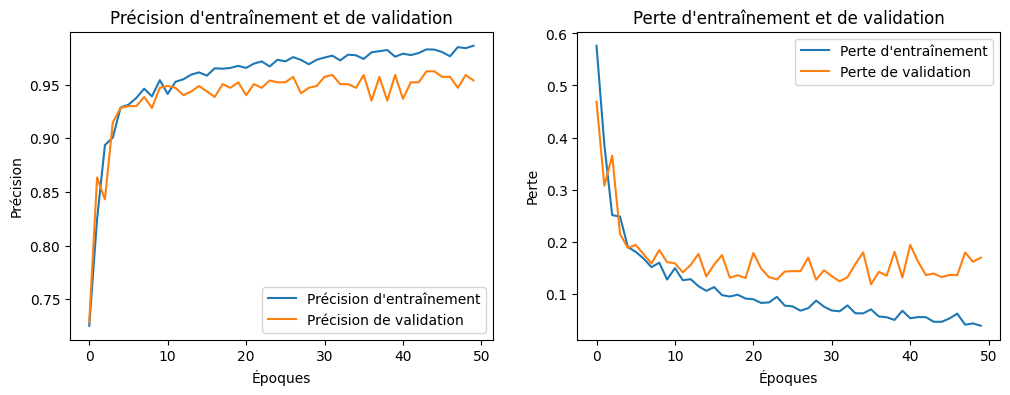

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9602 - loss: 0.1345 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 1:
perte: 0.17 précision: 0.95
AUC 0.9885
Prédictions
Counter({np.int64(1): 444, np.int64(0): 142}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.96      0.86      0.91       159
   Pneumonia       0.95      0.99      0.97       427

    accuracy                           0.95       586
   macro avg       0.96      0.92      0.94       586
weighted avg       0.95      0.95      0.95       586

Matrice de confusion


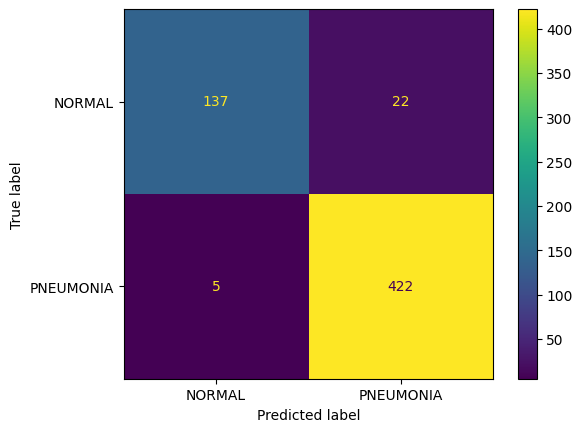

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7228 - loss: 0.5947 - val_accuracy: 0.7287 - val_loss: 0.5558
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.7915 - loss: 0.4286 - val_accuracy: 0.9010 - val_loss: 0.2475
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8907 - loss: 0.2615 - val_accuracy: 0.9249 - val_loss: 0.1962
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.9085 - loss: 0.2347 - val_accuracy: 0.9266 - val_loss: 0.1718
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.9247 - loss: 0.1998 - val_accuracy: 0.9352 - val_loss: 0.1775
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.9342 - loss: 0.1717 - val_accuracy: 0.9352 - val_loss: 0.1542
Epoch 7/50
83/83 - 1s - 7ms/step - accuracy: 0.9376 - loss: 0.1680 - val_accuracy: 0.9386 - val_loss: 0.1482
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.9436 - loss: 0.1473 - val_accuracy: 0.9437 - val_loss: 0.1237
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.9467 - loss: 0.1408 - val_accuracy: 0.9147 - val_loss: 0.2039
Epoch 10/50
8

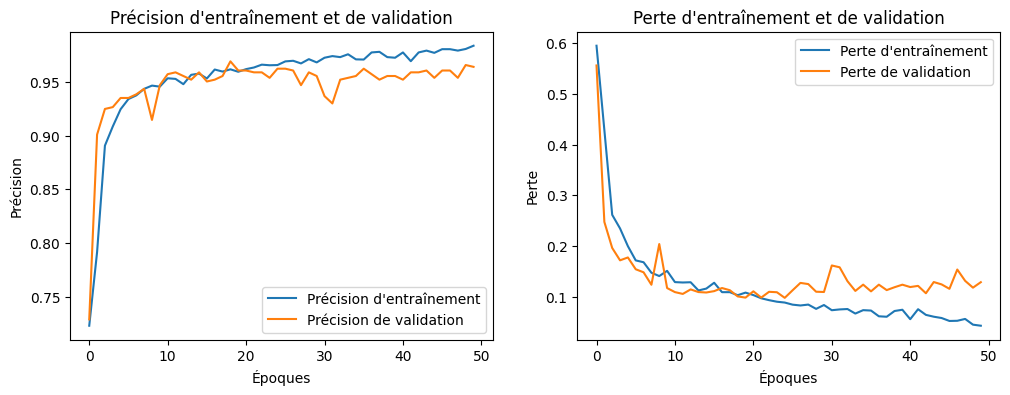

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9687 - loss: 0.1035 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 2:
perte: 0.13 précision: 0.96
AUC 0.9921
Prédictions
Counter({np.int64(1): 434, np.int64(0): 152}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.95      0.91      0.93       159
   Pneumonia       0.97      0.98      0.98       427

    accuracy                           0.96       586
   macro avg       0.96      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586

Matrice de confusion


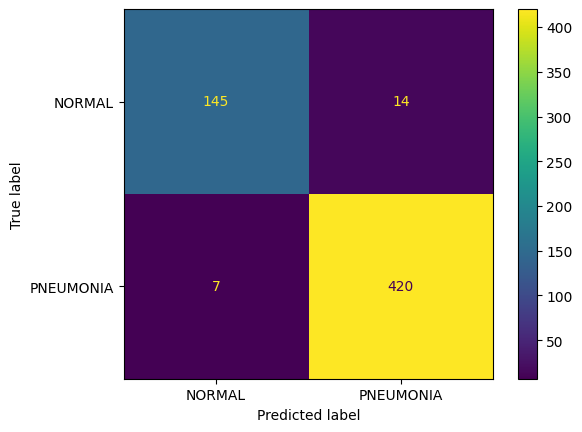

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 29ms/step - accuracy: 0.7220 - loss: 0.5925 - val_accuracy: 0.7287 - val_loss: 0.5421
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8040 - loss: 0.4071 - val_accuracy: 0.7833 - val_loss: 0.4357
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8880 - loss: 0.2757 - val_accuracy: 0.8925 - val_loss: 0.2430
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.9091 - loss: 0.2248 - val_accuracy: 0.9113 - val_loss: 0.2155
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9230 - loss: 0.2018 - val_accuracy: 0.9010 - val_loss: 0.2390
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9260 - loss: 0.1901 - val_accuracy: 0.9283 - val_loss: 0.1985
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9326 - loss: 0.1777 - val_accuracy: 0.9266 - val_loss: 0.2001
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9292 - loss: 0.1776 - val_accuracy: 0.9437 - val_loss: 0.1696
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9450 - loss: 0.1503 - val_accuracy: 0.9300 - val_loss: 0.2112
Epoch 10/50
8

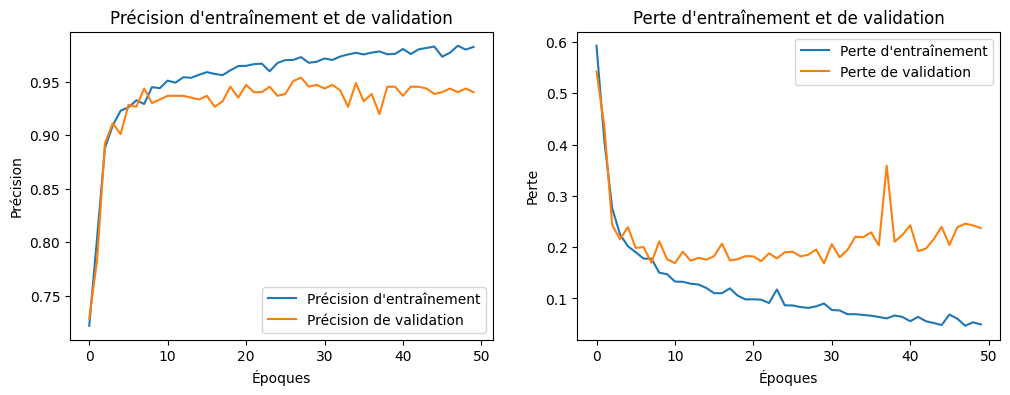

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9491 - loss: 0.2065 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 3:
perte: 0.24 précision: 0.94
AUC 0.9769
Prédictions
Counter({np.int64(1): 422, np.int64(0): 164}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.88      0.91      0.89       159
   Pneumonia       0.96      0.95      0.96       427

    accuracy                           0.94       586
   macro avg       0.92      0.93      0.93       586
weighted avg       0.94      0.94      0.94       586

Matrice de confusion


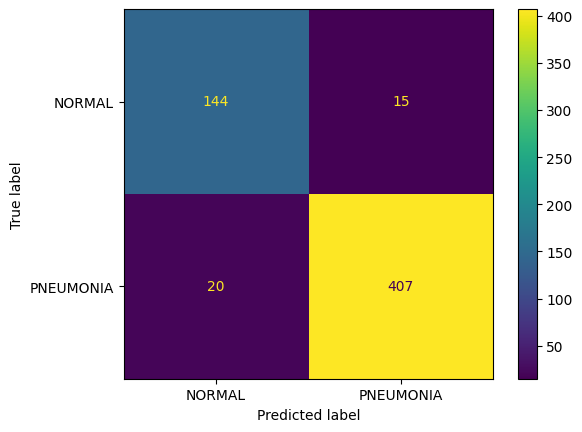

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7266 - loss: 0.5870 - val_accuracy: 0.7304 - val_loss: 0.5356
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8192 - loss: 0.3889 - val_accuracy: 0.8976 - val_loss: 0.2435
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8970 - loss: 0.2487 - val_accuracy: 0.9164 - val_loss: 0.2030
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.9099 - loss: 0.2297 - val_accuracy: 0.9283 - val_loss: 0.1888
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.9222 - loss: 0.1922 - val_accuracy: 0.9352 - val_loss: 0.1660
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9292 - loss: 0.1816 - val_accuracy: 0.9420 - val_loss: 0.1528
Epoch 7/50
83/83 - 1s - 7ms/step - accuracy: 0.9359 - loss: 0.1721 - val_accuracy: 0.9505 - val_loss: 0.1220
Epoch 8/50
83/83 - 1s - 6ms/step - accuracy: 0.9414 - loss: 0.1584 - val_accuracy: 0.9437 - val_loss: 0.1527
Epoch 9/50
83/83 - 1s - 6ms/step - accuracy: 0.9423 - loss: 0.1576 - val_accuracy: 0.9573 - val_loss: 0.1214
Epoch 10/50
8

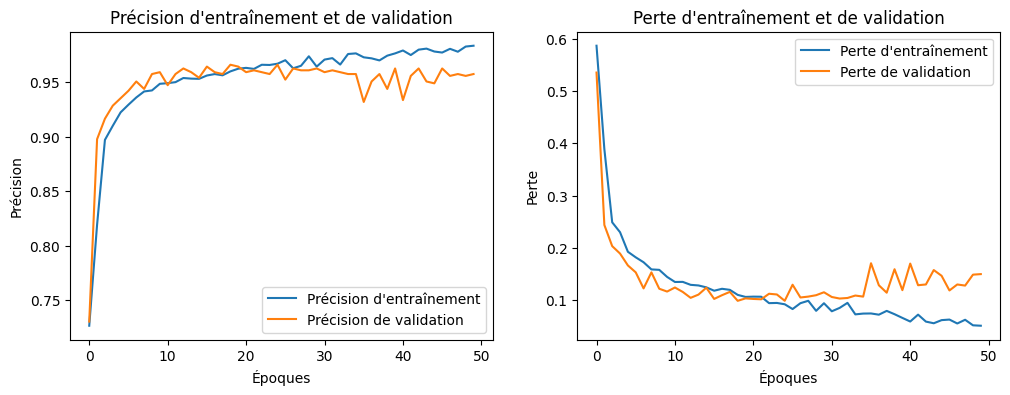

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9628 - loss: 0.1302 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 4:
perte: 0.15 précision: 0.96
AUC 0.9910
Prédictions
Counter({np.int64(1): 437, np.int64(0): 149}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.95      0.89      0.92       158
   Pneumonia       0.96      0.98      0.97       428

    accuracy                           0.96       586
   macro avg       0.95      0.94      0.94       586
weighted avg       0.96      0.96      0.96       586

Matrice de confusion


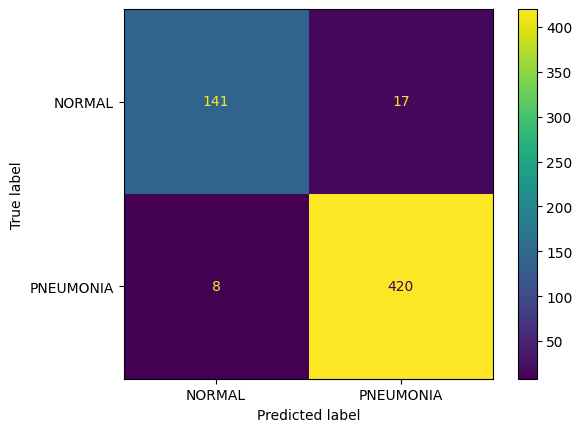

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7241 - loss: 0.5774 - val_accuracy: 0.7304 - val_loss: 0.4632
Epoch 2/50
83/83 - 1s - 6ms/step - accuracy: 0.8567 - loss: 0.3284 - val_accuracy: 0.9027 - val_loss: 0.2276
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.9028 - loss: 0.2394 - val_accuracy: 0.9096 - val_loss: 0.2087
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.9254 - loss: 0.1983 - val_accuracy: 0.9078 - val_loss: 0.2299
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9195 - loss: 0.2006 - val_accuracy: 0.9386 - val_loss: 0.1628
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9374 - loss: 0.1630 - val_accuracy: 0.9334 - val_loss: 0.1709
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9454 - loss: 0.1515 - val_accuracy: 0.9471 - val_loss: 0.1465
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9444 - loss: 0.1503 - val_accuracy: 0.9266 - val_loss: 0.1790
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9503 - loss: 0.1373 - val_accuracy: 0.9556 - val_loss: 0.1392
Epoch 10/50
8

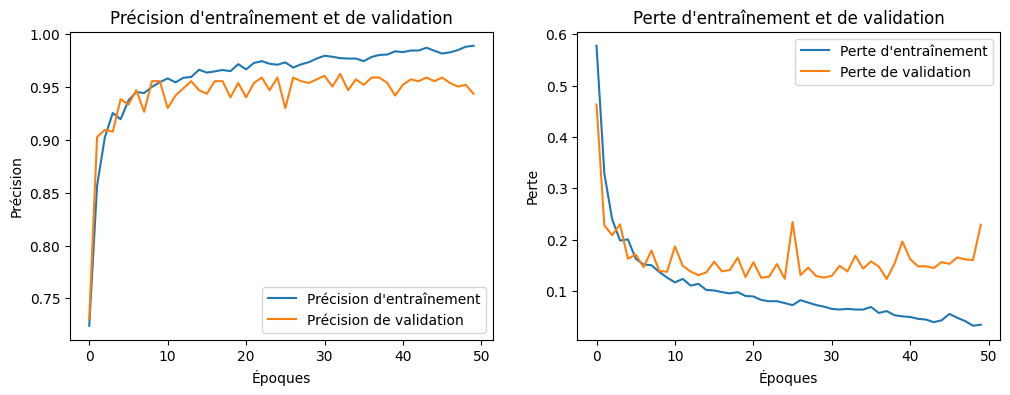

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9457 - loss: 0.2077 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 5:
perte: 0.23 précision: 0.94
AUC 0.9850
Prédictions
Counter({np.int64(1): 417, np.int64(0): 169}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90       158
   Pneumonia       0.97      0.95      0.96       428

    accuracy                           0.94       586
   macro avg       0.92      0.94      0.93       586
weighted avg       0.95      0.94      0.94       586

Matrice de confusion


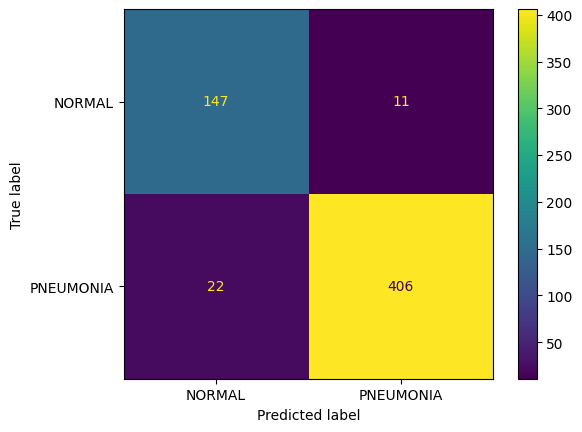

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.7260 - loss: 0.5857 - val_accuracy: 0.7304 - val_loss: 0.5032
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8326 - loss: 0.3682 - val_accuracy: 0.8874 - val_loss: 0.2815
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.8890 - loss: 0.2657 - val_accuracy: 0.9181 - val_loss: 0.2159
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.9173 - loss: 0.2152 - val_accuracy: 0.9283 - val_loss: 0.1863
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9230 - loss: 0.1956 - val_accuracy: 0.9283 - val_loss: 0.1721
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.9258 - loss: 0.1895 - val_accuracy: 0.9181 - val_loss: 0.2079
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9408 - loss: 0.1592 - val_accuracy: 0.9215 - val_loss: 0.1906
Epoch 8/50
83/83 - 1s - 6ms/step - accuracy: 0.9450 - loss: 0.1513 - val_accuracy: 0.9454 - val_loss: 0.1467
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9457 - loss: 0.1385 - val_accuracy: 0.9488 - val_loss: 0.1376
Epoch 10/50
8

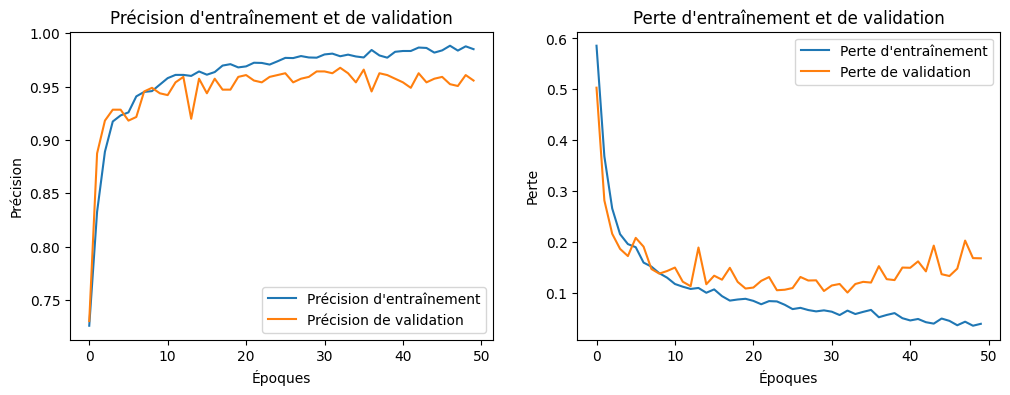

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9555 - loss: 0.1890 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 6:
perte: 0.17 précision: 0.96
AUC 0.9901
Prédictions
Counter({np.int64(1): 436, np.int64(0): 150}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.94      0.89      0.92       158
   Pneumonia       0.96      0.98      0.97       428

    accuracy                           0.96       586
   macro avg       0.95      0.94      0.94       586
weighted avg       0.96      0.96      0.96       586

Matrice de confusion


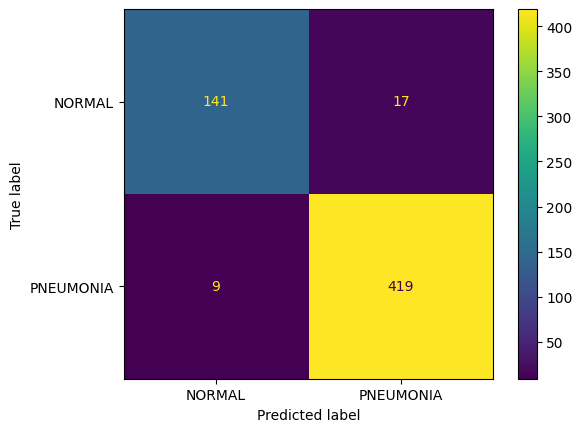

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7270 - loss: 0.5916 - val_accuracy: 0.7299 - val_loss: 0.5445
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8190 - loss: 0.3863 - val_accuracy: 0.8496 - val_loss: 0.3732
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.8847 - loss: 0.2817 - val_accuracy: 0.8974 - val_loss: 0.2270
Epoch 4/50
83/83 - 1s - 6ms/step - accuracy: 0.9165 - loss: 0.2184 - val_accuracy: 0.9197 - val_loss: 0.2050
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9254 - loss: 0.1989 - val_accuracy: 0.9368 - val_loss: 0.1761
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9332 - loss: 0.1781 - val_accuracy: 0.9350 - val_loss: 0.1636
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9353 - loss: 0.1620 - val_accuracy: 0.9453 - val_loss: 0.1469
Epoch 8/50
83/83 - 1s - 6ms/step - accuracy: 0.9503 - loss: 0.1436 - val_accuracy: 0.9487 - val_loss: 0.1416
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9452 - loss: 0.1463 - val_accuracy: 0.9556 - val_loss: 0.1237
Epoch 10/50
8

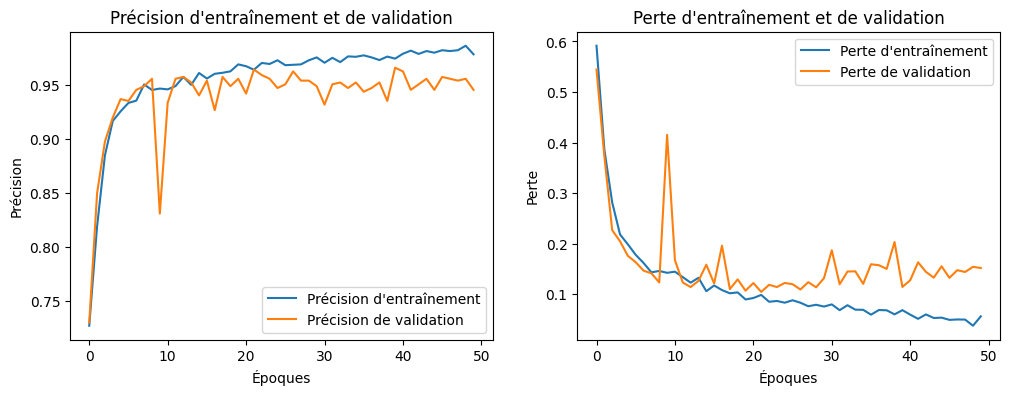

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9615 - loss: 0.1147 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 7:
perte: 0.15 précision: 0.95
AUC 0.9903
Prédictions
Counter({np.int64(1): 407, np.int64(0): 178}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.85      0.96      0.90       158
   Pneumonia       0.99      0.94      0.96       427

    accuracy                           0.95       585
   macro avg       0.92      0.95      0.93       585
weighted avg       0.95      0.95      0.95       585

Matrice de confusion


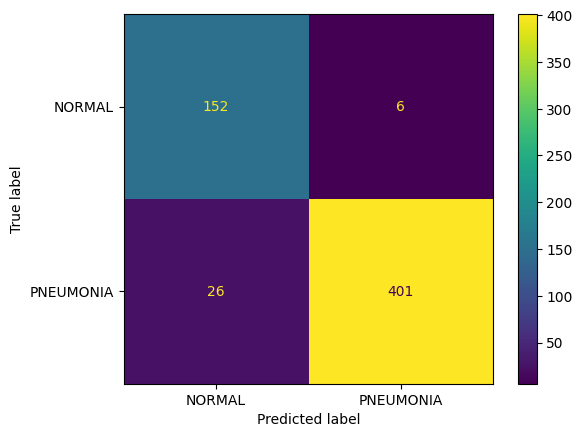

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7260 - loss: 0.5653 - val_accuracy: 0.7556 - val_loss: 0.4378
Epoch 2/50
83/83 - 1s - 6ms/step - accuracy: 0.8583 - loss: 0.3351 - val_accuracy: 0.9162 - val_loss: 0.2317
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.9006 - loss: 0.2403 - val_accuracy: 0.9350 - val_loss: 0.1833
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.9224 - loss: 0.1995 - val_accuracy: 0.8838 - val_loss: 0.2407
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9258 - loss: 0.1878 - val_accuracy: 0.9453 - val_loss: 0.1608
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9338 - loss: 0.1728 - val_accuracy: 0.9282 - val_loss: 0.1849
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9410 - loss: 0.1599 - val_accuracy: 0.9333 - val_loss: 0.1676
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9399 - loss: 0.1531 - val_accuracy: 0.9231 - val_loss: 0.2002
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9488 - loss: 0.1402 - val_accuracy: 0.9436 - val_loss: 0.1501
Epoch 10/50
8

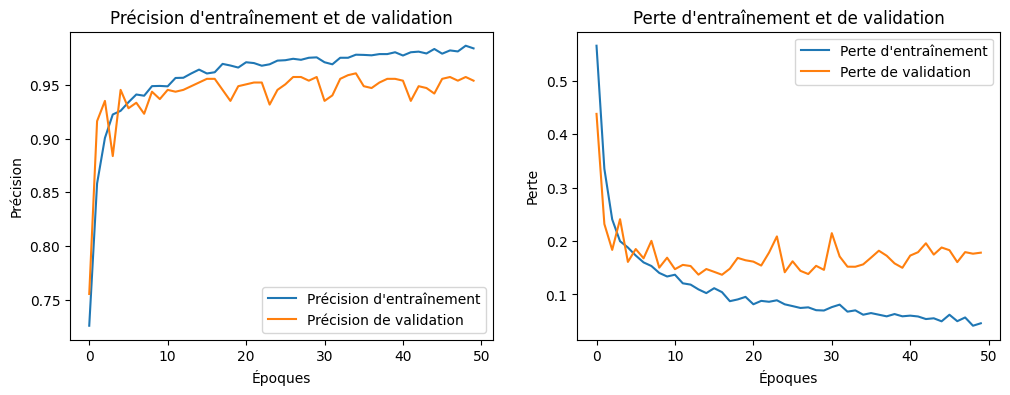

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9657 - loss: 0.1217 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 8:
perte: 0.18 précision: 0.95
AUC 0.9831
Prédictions
Counter({np.int64(1): 436, np.int64(0): 149}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.94      0.89      0.91       158
   Pneumonia       0.96      0.98      0.97       427

    accuracy                           0.95       585
   macro avg       0.95      0.93      0.94       585
weighted avg       0.95      0.95      0.95       585

Matrice de confusion


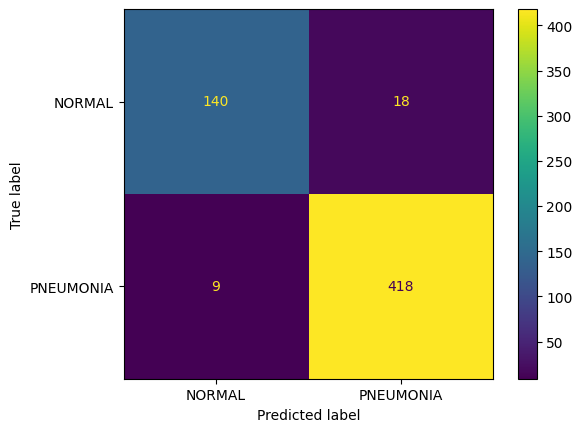

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 26ms/step - accuracy: 0.7278 - loss: 0.5909 - val_accuracy: 0.7299 - val_loss: 0.5230
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8253 - loss: 0.3675 - val_accuracy: 0.8581 - val_loss: 0.3186
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.8957 - loss: 0.2651 - val_accuracy: 0.8803 - val_loss: 0.2639
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.8989 - loss: 0.2429 - val_accuracy: 0.9043 - val_loss: 0.2462
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9188 - loss: 0.2116 - val_accuracy: 0.8735 - val_loss: 0.2696
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9298 - loss: 0.1832 - val_accuracy: 0.9111 - val_loss: 0.2246
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9366 - loss: 0.1649 - val_accuracy: 0.9316 - val_loss: 0.1694
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9425 - loss: 0.1497 - val_accuracy: 0.9436 - val_loss: 0.1654
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9503 - loss: 0.1353 - val_accuracy: 0.9402 - val_loss: 0.1535
Epoch 10/50
8

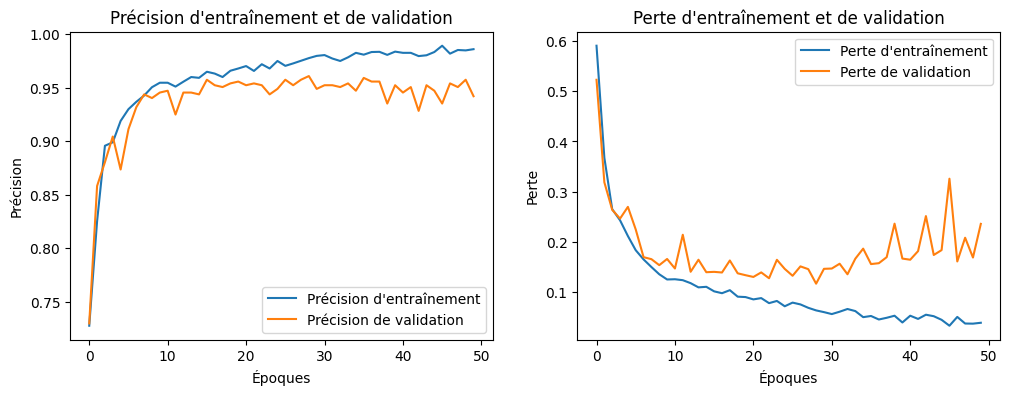

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9384 - loss: 0.2195 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Partition numéro 9:
perte: 0.24 précision: 0.94
AUC 0.9878
Prédictions
Counter({np.int64(1): 451, np.int64(0): 134}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.96      0.82      0.88       158
   Pneumonia       0.94      0.99      0.96       427

    accuracy                           0.94       585
   macro avg       0.95      0.90      0.92       585
weighted avg       0.94      0.94      0.94       585

Matrice de confusion


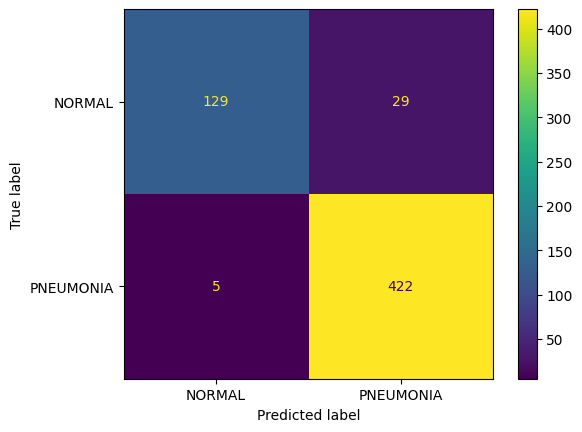

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7338 - loss: 0.5518 - val_accuracy: 0.8786 - val_loss: 0.3426
Epoch 2/50
83/83 - 1s - 6ms/step - accuracy: 0.8746 - loss: 0.3106 - val_accuracy: 0.9265 - val_loss: 0.1825
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.9067 - loss: 0.2340 - val_accuracy: 0.9282 - val_loss: 0.1887
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.9287 - loss: 0.1957 - val_accuracy: 0.9436 - val_loss: 0.1423
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9317 - loss: 0.1765 - val_accuracy: 0.9197 - val_loss: 0.2199
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9385 - loss: 0.1659 - val_accuracy: 0.9538 - val_loss: 0.1365
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9512 - loss: 0.1385 - val_accuracy: 0.9556 - val_loss: 0.1262
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9562 - loss: 0.1287 - val_accuracy: 0.9521 - val_loss: 0.1249
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9548 - loss: 0.1267 - val_accuracy: 0.9641 - val_loss: 0.1109
Epoch 10/50
8

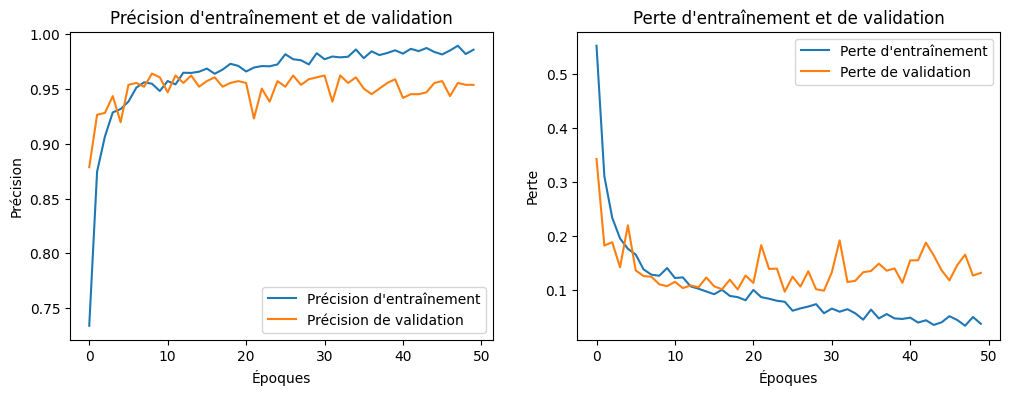

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9548 - loss: 0.1130 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 10:
perte: 0.13 précision: 0.95
AUC 0.9911
Prédictions
Counter({np.int64(1): 428, np.int64(0): 157}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.92      0.91      0.91       158
   Pneumonia       0.97      0.97      0.97       427

    accuracy                           0.95       585
   macro avg       0.94      0.94      0.94       585
weighted avg       0.95      0.95      0.95       585

Matrice de confusion


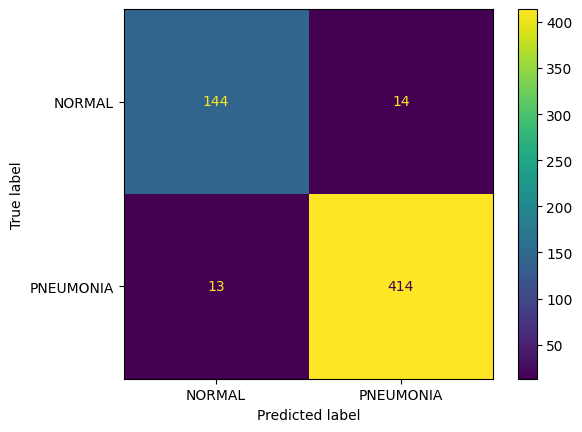

Le meilleur modèle a été sauvegardé avec un ROC de: 0.9920757662792924
Fin de l'entraînement
Résultats ROC:
0.9885407921287909

0.9920757662792924

0.9768901064910963

0.9909943215426475

0.9850348988524784

0.9900922749319769

0.9902765837607092

0.9831100109684878

0.9878160851391813

0.9910621646458957

Tableau enregistré avec succès dans '1_1_resultatsROC.txt'


In [28]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = load_data(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(img_rows,'x', img_cols, 'taille de l\'image')  # Traducción: image size
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    for train_index, test_index in kf.split(X, y):
        # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)


        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred[:, 1])
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "1_1_resultatsROC.txt")

if __name__ == '__main__':
    path = r"..\data\external\chest_xray"
    main(path)
